# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

In [4]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import requests

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/'

fileNames = ["dom.png"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

def plot(*args):
    count = len(args)
    fig, ax = plt.subplots(1,count)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    if count==1:
        ax.imshow(args[0], cmap="gray")
    else:
        for i in range(len(ax)):
            ax[i].imshow(args[i], cmap="gray")
    plt.show()

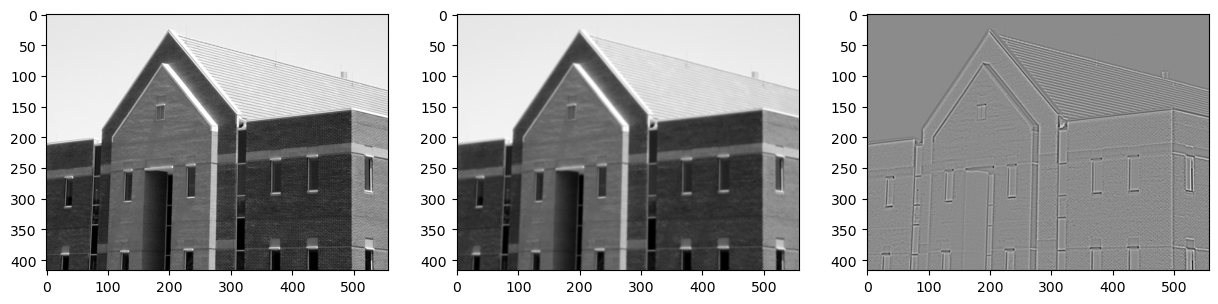

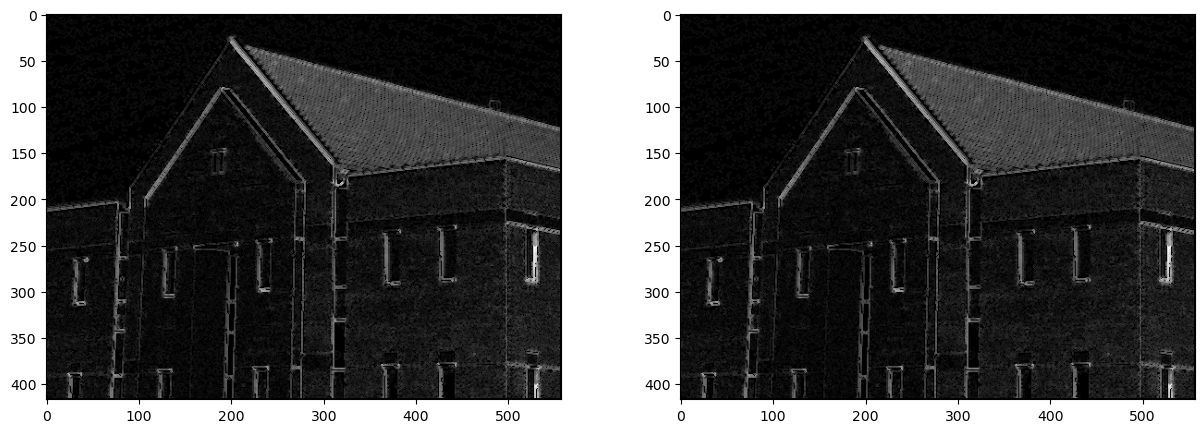

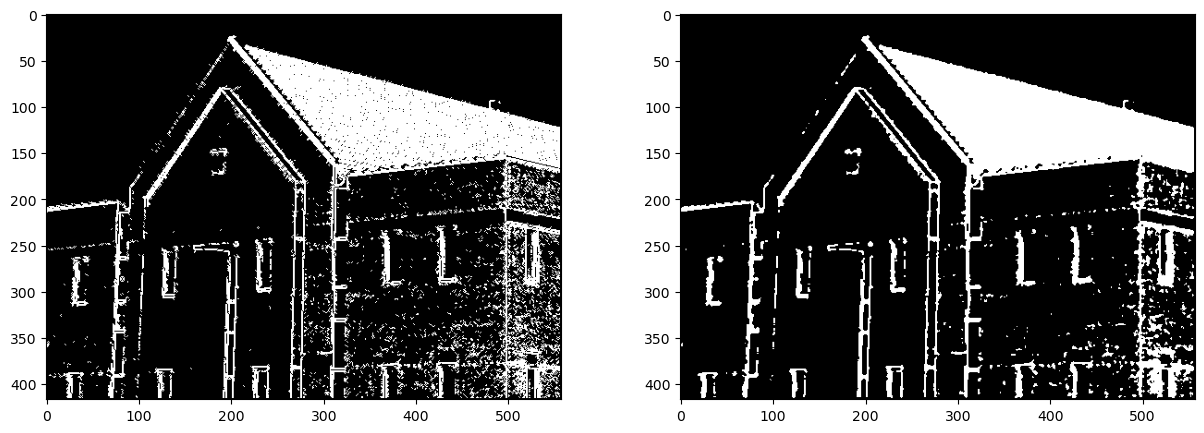

In [9]:
image = cv2.imread('dom.png',cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(image, (5,5), 1)
laplas = cv2.Laplacian(blurred, cv2.CV_32F)
plot(image, blurred, laplas)


def crossing(gaus, threshold, lap_image):
    
    (x,y) = lap_image.shape
    new_image = np.zeros(lap_image.shape)
    
    for i in range(1, y-1):
        for j in range(1, x-1):
            context = lap_image[j-1:j+2,i-1:i+2]
            min_val, max_val = np.min(context), np.max(context)
            if(min_val*max_val)<0:
                if(lap_image[j,i]>0):
                    new_image[j,i]=lap_image[j,i]+abs(min_val)
                if(lap_image[j,i]<0):
                    new_image[j,i]=abs(lap_image[j,i])+max_val
                    
    normalized_res=np.zeros(new_image.shape,"uint8")
    normalized_res = cv2.normalize(new_image,normalized_res,0,255,cv2.NORM_MINMAX)
    normalized_res = normalized_res.astype("uint8")
    plot(new_image,normalized_res)
    
    bin_image = new_image>threshold
    bin_image = bin_image.astype("uint8")

    
    blurred_res = cv2.medianBlur(bin_image, 3)
    plot(bin_image, blurred_res)
    
crossing(1,13, laplas)
# # plot(laplas)
# # print(laplas)



# img = cv2.imread('dom.png',cv2.IMREAD_GRAYSCALE)
# LoG = cv2.Laplacian(blurred, cv2.CV_32F)
# thres = np.absolute(LoG).mean() * 0.75
# output = np.zeros(LoG.shape)
# w = output.shape[1]
# h = output.shape[0]

# for y in range(1, h - 1):
#     for x in range(1, w - 1):
#         patch = LoG[y-1:y+2, x-1:x+2]
#         p = LoG[y, x]
#         maxP = patch.max()
#         minP = patch.min()
#         if (p > 0):
#             zeroCross = True if minP < 0 else False
#         else:
#             zeroCross = True if maxP > 0 else False
#         if ((maxP - minP) > thres) and zeroCross:
#             output[y, x] = 1
# plot(output)

In [5]:
def canny_edge_detection(image, low_threshold, high_threshold):
    # 1. Filtracja Gaussa
    blurred = cv2.GaussianBlur(image, (5, 5), 20)

    # 2. Obliczanie gradientów pionowych i poziomych (Sobel)
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=7)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=7)

    # 3. Obliczanie amplitudy i kątów gradientu
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    angle = np.arctan2(sobely, sobelx) * (180 / np.pi)

    # 4. Kwantyzacja kątów gradientu
    quantized_angle = np.zeros_like(angle, dtype=np.uint8)
    quantized_angle[(angle >= -22.5) & (angle < 22.5)] = 0
    quantized_angle[(angle >= 22.5) & (angle < 67.5)] = 45
    quantized_angle[(angle >= 67.5) & (angle < 112.5)] = 90
    quantized_angle[(angle >= 112.5) & (angle < 157.5)] = 135
    quantized_angle[(angle >= 157.5) | (angle < -157.5)] = 0
    quantized_angle[(angle >= -157.5) & (angle < -112.5)] = 45
    quantized_angle[(angle >= -112.5) & (angle < -67.5)] = 90
    quantized_angle[(angle >= -67.5) & (angle < -22.5)] = 135

    # 5. Eliminacja nieistotnych pikseli (nonmaximal suppression)
    nonmax_suppressed = np.zeros_like(magnitude)
    rows, cols = magnitude.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            direction = quantized_angle[i, j]
            if direction == 0:
                neighbors = [magnitude[i, j - 1], magnitude[i, j + 1]]
            elif direction == 45:
                neighbors = [magnitude[i - 1, j - 1], magnitude[i + 1, j + 1]]
            elif direction == 90:
                neighbors = [magnitude[i - 1, j], magnitude[i + 1, j]]
            elif direction == 135:
                neighbors = [magnitude[i - 1, j + 1], magnitude[i + 1, j - 1]]

            if magnitude[i, j] >= max(neighbors):
                nonmax_suppressed[i, j] = magnitude[i, j]

    # 6. Binaryzacja z histerezą
    edges = np.zeros_like(nonmax_suppressed)
    high_threshold_value = nonmax_suppressed.max() * high_threshold
    low_threshold_value = high_threshold_value * low_threshold

    strong_edges_i, strong_edges_j = np.where(nonmax_suppressed >= high_threshold_value)
    weak_edges_i, weak_edges_j = np.where((nonmax_suppressed >= low_threshold_value) & (nonmax_suppressed < high_threshold_value))

    edges[strong_edges_i, strong_edges_j] = 255
    edges[weak_edges_i, weak_edges_j] = 50  # 50 represents weak edges

    # 7. Procedura propagacji krawędzi
    stack = list(zip(strong_edges_i, strong_edges_j))
    visited = set(stack)
    while stack:
        current_i, current_j = stack.pop()
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = current_i + di, current_j + dj
                if (ni, nj) not in visited and 0 <= ni < rows and 0 <= nj < cols and edges[ni, nj] == 50:
                    edges[ni, nj] = 255
                    stack.append((ni, nj))
                    visited.add((ni, nj))

    return edges

In [6]:
def canny(I, tl, th):
  gauss = cv2.GaussianBlur(I, (3,3), 0)


  gx = cv2.Sobel(gauss, cv2.CV_64F, 1, 0, ksize=7)
  gy = cv2.Sobel(gauss, cv2.CV_64F, 0, 1, ksize=7)

  #gx = gx.astype('float')
  #gy = gy.astype('float')

  M = np.sqrt(gx**2 + gy**2)
  alpha = np.arctan2(gy, gx) * (180 / np.pi)

  quantized_angle = np.zeros_like(alpha, dtype=np.uint8)
  quantized_angle[(alpha >= -22.5) & (alpha < 22.5)] = 2
  quantized_angle[(alpha >= 22.5) & (alpha < 67.5)] = 3
  quantized_angle[(alpha >= 67.5) & (alpha < 112.5)] = 1
  quantized_angle[(alpha >= 112.5) & (alpha < 157.5)] = 4
  quantized_angle[(alpha >= 157.5) | (alpha < -157.5)] = 2
  quantized_angle[(alpha >= -157.5) & (alpha < -112.5)] = 3
  quantized_angle[(alpha >= -112.5) & (alpha < -67.5)] = 1
  quantized_angle[(alpha >= -67.5) & (alpha < -22.5)] = 4

  gn = nonmax(quantized_angle, M)

  gnh = gn >= th
  gnl = (gn < th) & (gn >= tl)


  coord_list = []

  for i in range(0, gnh.shape[0]):
    for j in range(0, gnh.shape[1]):
      if gnh[i, j]:
        coord_list.append([i, j])


  rows, cols = M.shape

  edges = np.zeros_like(gn)
  high_threshold_value = gn.max() * th
  low_threshold_value = high_threshold_value * tl

  strong_edges_i, strong_edges_j = np.where(gn >= high_threshold_value)
  weak_edges_i, weak_edges_j = np.where((gn >= low_threshold_value) & (gn < high_threshold_value))

  edges[strong_edges_i, strong_edges_j] = 255
  edges[weak_edges_i, weak_edges_j] = 50  # 50 represents weak edges

    # 7. Procedura propagacji krawędzi
  stack = list(zip(strong_edges_i, strong_edges_j))
  visited = set(stack)
  while stack:
      current_i, current_j = stack.pop()
      for di in range(-1, 2):
          for dj in range(-1, 2):
              ni, nj = current_i + di, current_j + dj
              if (ni, nj) not in visited and 0 <= ni < rows and 0 <= nj < cols and edges[ni, nj] == 50:
                  edges[ni, nj] = 255
                  stack.append((ni, nj))
                  visited.add((ni, nj))


  return gnh, edges

def nonmax(angles, M):

  gn = np.zeros(M.shape)

  for i in range(1, M.shape[0]-1):
    for j in range(1, M.shape[1]-1):
      window = M[i-1:i+2, j-1:j+2]
      n_1 = window[1, 1]
      n_2 = window[1, 1]

      if angles[i, j] == 1: #Pionowy
        n_1 = window[0, 1]
        n_2 = window[2, 1]
      elif angles[i, j] == 2: #Poziomy
        n_1 = window[1, 0]
        n_2 = window[1, 2]
      elif angles[i, j] == 3: #Skosny lewy
        n_1 = window[0, 0]
        n_2 = window[2, 2]
      else: #Skosny prawy
        n_1 = window[2, 0]
        n_2 = window[0, 2]


      if n_1 <= window[1, 1] and n_2 <= window[1, 1]:
        gn[i, j] = window[1, 1]
  return gn

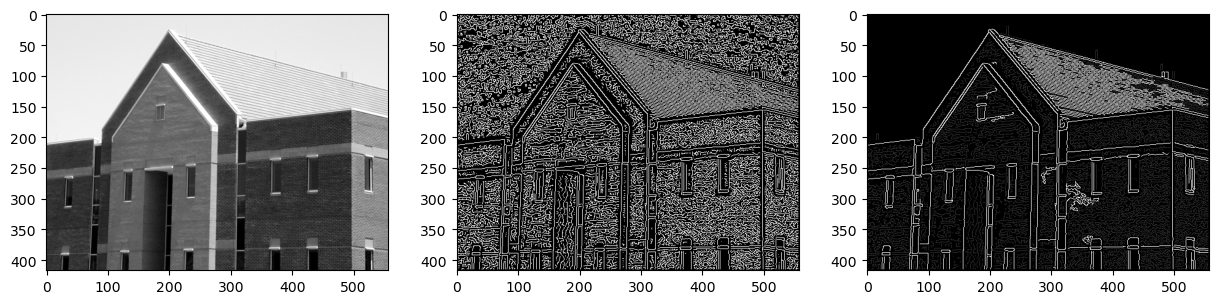

In [8]:
house = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)

gnh, edges = canny(house, 0.10, 0.15)
sol2 = canny_edge_detection(house, 100, 120)

plot(house, gnh, edges)

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

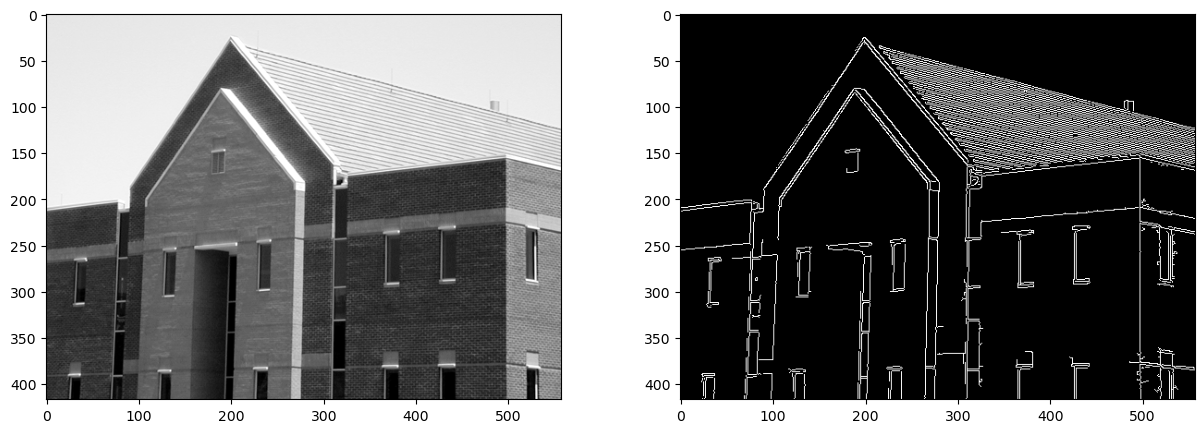

In [16]:
image = cv2.imread('dom.png',cv2.IMREAD_GRAYSCALE)
res = cv2.Canny(image, 100,240,None,3,1)
plot(image,res)